<a href="https://colab.research.google.com/github/faiyaz106/Adult-Income-class-classification-/blob/main/Bird_Classification_Using_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bird Classification using ResNet50

In [2]:
# Import important Library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from  tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
# Loading the data from google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [85]:
#Load the image
BATCH_SIZE = 32
IMG_SIZE = (64, 64)  
directory = "/content/drive/MyDrive/Bird_Data/training_set"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
## Test Set
test_directory = "/content/drive/MyDrive/Bird_Data/test_set"
test_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 239 files belonging to 2 classes.
Using 192 files for training.
Found 239 files belonging to 2 classes.
Using 47 files for validation.
Found 35 files belonging to 2 classes.


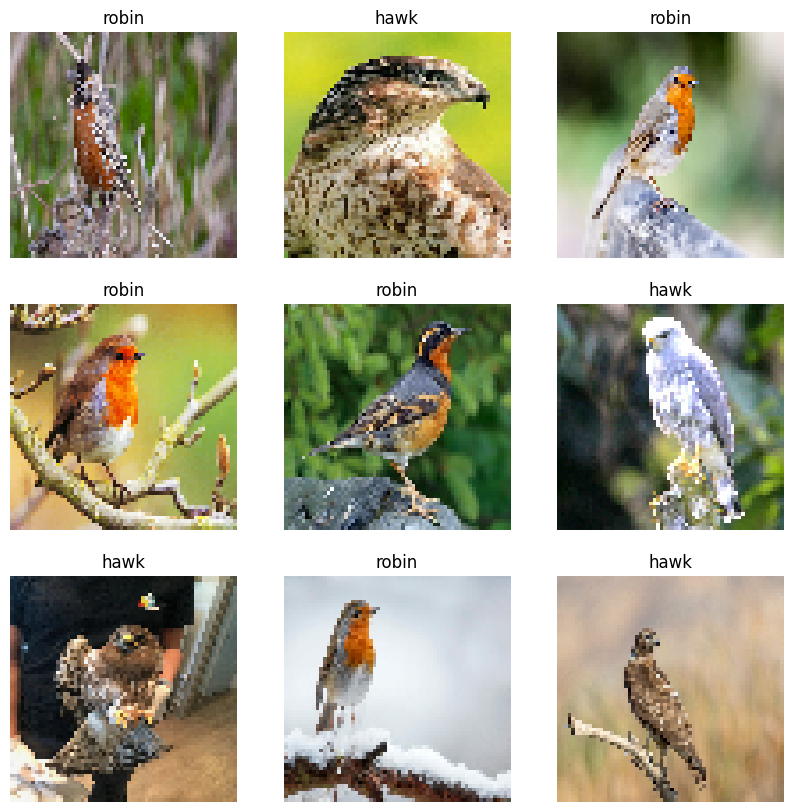

In [86]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Preprocess the Augment the Data

In [ ]:
# Build the Resnet block from Scratch:
#1. Define the Identity Block ( input shape is same as output shape )
#2. Define the Convolution Block (input and output have different shape)

### The details of this ResNet-50 model are:
    Zero-padding pads the input with a pad of (3,3)

    Stage 1:
    The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    BatchNorm is applied to the 'channels' axis of the input.
    MaxPooling uses a (3,3) window and a (2,2) stride.

    Stage 2:
    The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
    
    Stage 3:
    The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
    
    Stage 4:
    The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
    
    Stage 5:
    The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.

    The 2D Average Pooling uses a window of shape (2,2).
    The 'flatten' layer doesn't have any hyperparameters.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [88]:
def identity_block(X,f,filters,training=True):
  """
  X: Input tensor having shape (m, n_h, n_w, c) 
  f: integer, shows filter shape i.e (f,f)
  filters: list of filters, contains the number of filters for each conv layers in main path
  training: True in training mode, else False in inference mode
  """
  F1,F2,F3=filters 
  X_skip=X  # Define the shortcut connection which will be added before 
  
  # 1st component
  X=tfl.Conv2D(filters=F1,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 2nd Component
  X=tfl.Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding='same')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)  
  
  # 3rd Component
  X=tfl.Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  # Concatenate the X_Skip with X
  X=tfl.Add()([X,X_skip])

  # Pass through ReLU
  X=tfl.ReLU()(X)

  return X

In [103]:
def conv_block(X,f,filters,s,training=True):
  """
  X: Input tensor having shape (m, n_h, n_w, c) 
  f: integer, i.e kernel size:(f,f)
  filters: list of filters, contains the number of filters for each conv layers in main path
  training: True in training mode, else False in inference mode
  """
  X_skip=X
  F1,F2,F3=filters

  # 1st Component
  X=tfl.Conv2D(filters=F1,kernel_size=1,strides=(s,s),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 2nd Component
  X=tfl.Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding='same')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)
  X=tfl.ReLU()(X)

  # 3rd Component
  X=tfl.Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid')(X)
  X=tfl.BatchNormalization(axis=-1)(X,training=training)

  # Skip Connection (Conv+Batch norm)
  X_skip=tfl.Conv2D(filters=F3,kernel_size=1, strides=(s,s), padding='valid')(X_skip)
  X_skip=tfl.BatchNormalization()(X_skip,training=training)

  # Merging the X and X_skip
  X=tfl.Add()([X,X_skip])

  # ReLU layer for Merged X
  X=tfl.ReLU()(X)

  return X


In [109]:
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

In [110]:
Z=conv_block(X,2,[10,20,3],2)


In [111]:
Z.shape

TensorShape([3, 2, 2, 3])

In [84]:
X.shape

(3, 4, 4, 3)